/Users/matmang/opt/anaconda3/envs/bert-study/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/matmang/opt/anaconda3/envs/bert-study/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/matmang/opt/anaconda3/envs/bert-study/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' 

Accuracy: 0.792342186961021


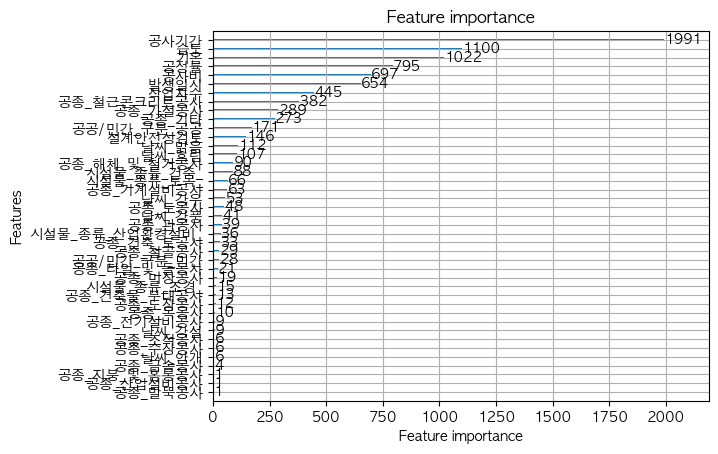

In [77]:
import sys
sys.path.append('..')

import lightgbm as lgb
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from cleansing.data_cleansing import preprocess_data_classification
import numpy as np

X_train, X_test, y_train, y_test = preprocess_data_classification()

# 가중치 생성
weights_train = np.ones_like(y_train)  # 기본 가중치 1로 초기화
weights_train[y_train == 2] = 80  # 상에 대한 가중치를 10으로 설정

# LightGBM 데이터셋으로 변환
lgb_train = lgb.Dataset(X_train, label=y_train, weight=weights_train)
lgb_eval = lgb.Dataset(X_test, label=y_test, reference=lgb_train)

# LightGBM 모델 설정
params = {
    'objective': 'multiclass',
    'num_class': 3,  # 클래스 개수 (상, 중, 하)
    'metric': 'multi_logloss',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'max_depth': 6,
    'min_child_weight': 0.1,
    'verbosity': -1
}

# 모델 학습
num_round = 100
bst = lgb.train(params, lgb_train, num_round, valid_sets=[lgb_train, lgb_eval], early_stopping_rounds=10, verbose_eval=0)

# 모델 예측
y_pred_lgb = bst.predict(X_test, num_iteration=bst.best_iteration)
y_pred_lgb_class = np.argmax(y_pred_lgb, axis=1)  # 확률값에서 가장 큰 값의 인덱스로 클래스 예측

# 정확도 계산
accuracy = accuracy_score(y_test, y_pred_lgb_class)
print("Accuracy:", accuracy)

plt.rcParams['font.family'] = 'AppleGothic'

# 모델 feature importance 출력
lgb.plot_importance(bst)
plt.show()


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

              precision    recall  f1-score   support

           0       0.95      0.44      0.60      1610
           1       1.00      0.00      0.00      1231
           2       0.02      0.86      0.05        58

    accuracy                           0.26      2899
   macro avg       0.66      0.43      0.22      2899
weighted avg       0.95      0.26      0.34      2899



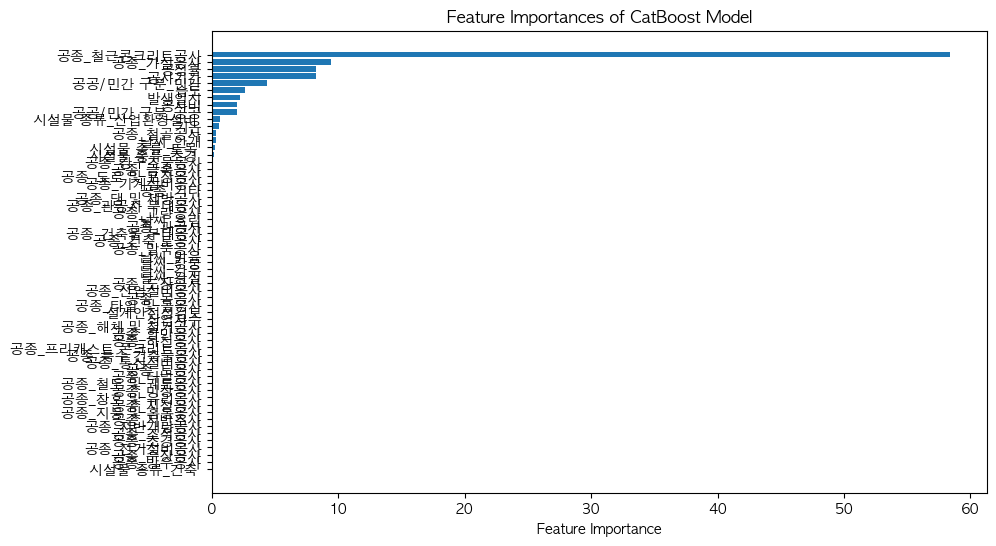

In [78]:
import catboost as cb
from sklearn.metrics import classification_report

# 중증 사고에 대한 가중치 생성
sample_weights = np.ones_like(y_train, dtype=np.float64)
# sample_weights[y_train >= 1] = 2.0
sample_weights[y_train >= 2] = 80.0  # 심각한 사고에 대한 가중치를 10으로 설정

sample_weights = sample_weights.reshape(-1)

# CatBoost 데이터셋으로 변환
cb_train = cb.Pool(X_train, label=y_train.astype('int'), weight=sample_weights)
cb_eval = cb.Pool(X_test, label=y_test.astype('int'))

# 모델 학습
model = cb.CatBoostClassifier(
    loss_function='MultiClass',
    eval_metric='MultiClass',
    learning_rate=0.05,
    iterations=1000,
    depth=6,
    l2_leaf_reg=3,
    random_seed=42
)
model.fit(cb_train, eval_set=cb_eval, early_stopping_rounds=10, verbose=0, plot=True)

# 모델 예측
y_pred_cb = model.predict(X_test)

# 분류 보고서 출력
report = classification_report(y_test.astype('int'), y_pred_cb)
print(report)

# 특성 중요도
feature_importances = model.get_feature_importance(cb_train)

# 특성 이름
feature_names = X_train.columns

# 특성 중요도를 내림차순으로 정렬
sorted_idx = feature_importances.argsort()

# 특성 중요도를 내림차순으로 정렬된 순서로 정렬
feature_names_sorted = feature_names[sorted_idx]
feature_importances_sorted = feature_importances[sorted_idx]

# 특성 중요도 그래프 그리기
plt.figure(figsize=(10, 6))
plt.barh(range(X_train.shape[1]), feature_importances_sorted, align='center')
plt.yticks(range(X_train.shape[1]), feature_names_sorted)
plt.xlabel('Feature Importance')
plt.title('Feature Importances of CatBoost Model')
plt.show()


Accuracy: 0.792342186961021
Confusion Matrix:
[[1520    3   87]
 [  48  754  429]
 [  12   23   23]]
Classification Report:
              precision    recall  f1-score   support

         0.0       0.96      0.94      0.95      1610
         1.0       0.97      0.61      0.75      1231
         2.0       0.04      0.40      0.08        58

    accuracy                           0.79      2899
   macro avg       0.66      0.65      0.59      2899
weighted avg       0.95      0.79      0.85      2899



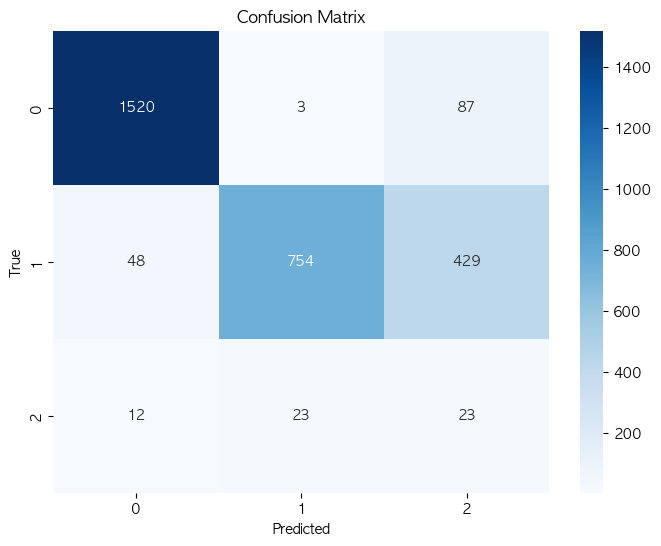

In [79]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns

# 정확도 계산
accuracy = accuracy_score(y_test, y_pred_lgb_class)
print("Accuracy:", accuracy)

# 혼동 행렬 계산
cm = confusion_matrix(y_test, y_pred_lgb_class)
print("Confusion Matrix:")
print(cm)

# 분류 보고서 출력
classification_rep = classification_report(y_test, y_pred_lgb_class)
print("Classification Report:")
print(classification_rep)

class_labels = y_test.columns

# 혼동 행렬 시각화
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

y_test_combined shape: (2899, 1)
y_pred_combined shape: (2899,)
y_test_combined values: [0. 1.]
y_pred_combined values: [0 1]
Classification Report:
              precision    recall  f1-score   support

         0.0       0.96      0.94      0.95      1610
         1.0       0.93      0.95      0.94      1289

    accuracy                           0.95      2899
   macro avg       0.95      0.95      0.95      2899
weighted avg       0.95      0.95      0.95      2899



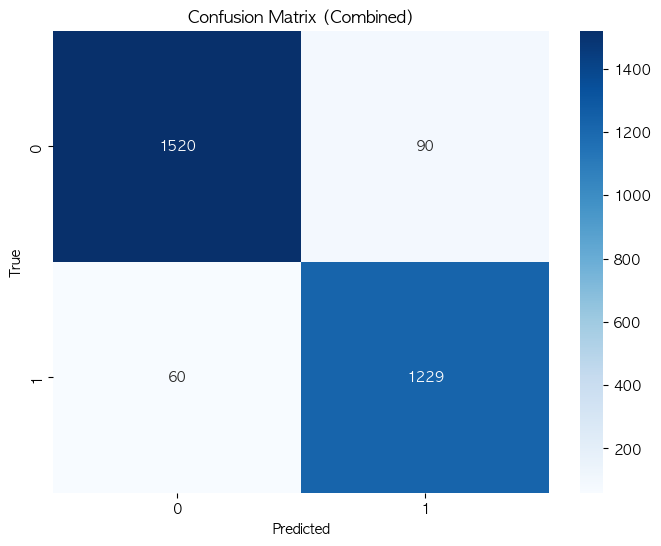

In [80]:
# y_test와 y_pred_lgb_class에서 값이 1, 2인 경우를 하나로 묶음
y_test_combined = np.where(np.isin(y_test, [1, 2]), 1, y_test)
y_pred_combined = np.where(np.isin(y_pred_lgb_class, [2]), 1, y_pred_lgb_class)

print("y_test_combined shape:", y_test_combined.shape)
print("y_pred_combined shape:", y_pred_combined.shape)
print("y_test_combined values:", np.unique(y_test_combined))
print("y_pred_combined values:", np.unique(y_pred_combined))


# 혼동 행렬 계산
cm_combined = confusion_matrix(y_test_combined, y_pred_combined)

# 분류 보고서 출력
classification_rep = classification_report(y_test_combined, y_pred_combined)
print("Classification Report:")
print(classification_rep)

# 혼동 행렬 시각화
plt.figure(figsize=(8, 6))
sns.heatmap(cm_combined, annot=True, cmap='Blues', fmt='d')
plt.title('Confusion Matrix (Combined)')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


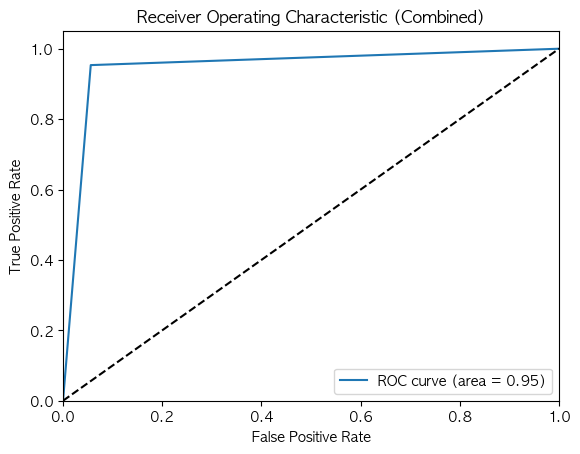

In [81]:
from sklearn.metrics import roc_curve, auc

# ROC 곡선 계산
fpr, tpr, thresholds = roc_curve(y_test_combined, y_pred_combined)
roc_auc = auc(fpr, tpr)

# ROC 곡선 그리기
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (Combined)')
plt.legend(loc="lower right")
plt.show()


Accuracy: 0.26146947223180406
Confusion Matrix:
[[ 707    0  903]
 [  30    1 1200]
 [   8    0   50]]
Classification Report:
              precision    recall  f1-score   support

         0.0       0.95      0.44      0.60      1610
         1.0       1.00      0.00      0.00      1231
         2.0       0.02      0.86      0.05        58

    accuracy                           0.26      2899
   macro avg       0.66      0.43      0.22      2899
weighted avg       0.95      0.26      0.34      2899



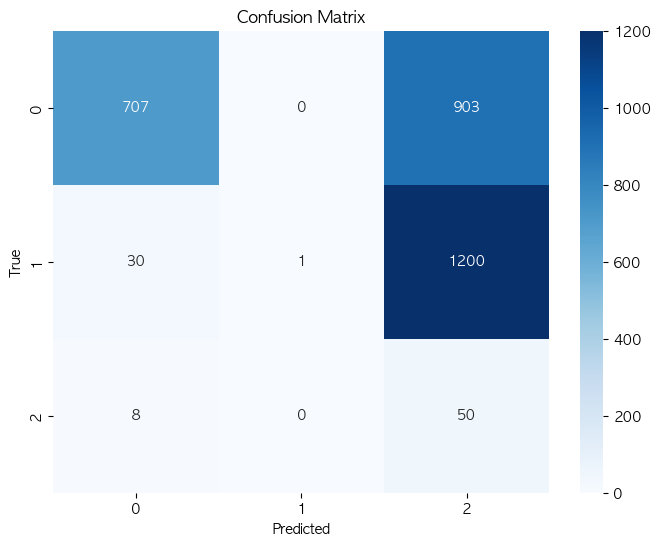

In [82]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# 정확도 계산
accuracy = accuracy_score(y_test, y_pred_cb)
print("Accuracy:", accuracy)

# 혼동 행렬 계산
cm = confusion_matrix(y_test, y_pred_cb)
print("Confusion Matrix:")
print(cm)

# 분류 보고서 출력
classification_rep = classification_report(y_test, y_pred_cb)
print("Classification Report:")
print(classification_rep)

class_labels = y_test.columns

# 혼동 행렬 시각화
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [83]:
print(X_test.iloc[0])
y_pred_lgb = bst.predict(X_test.iloc[0], num_iteration=bst.best_iteration)
y_pred_lgb_class = np.argmax(y_pred_lgb, axis=1)
y_pred_lgb_class

시설물 종류_건축          0.000000e+00
시설물 종류_산업환경설비      0.000000e+00
시설물 종류_조경          1.000000e+00
시설물 종류_토목          0.000000e+00
공공/민간 구분_공공        1.000000e+00
공공/민간 구분_민간        0.000000e+00
날씨_강설              0.000000e+00
날씨_강우              0.000000e+00
날씨_강풍              0.000000e+00
날씨_맑음              1.000000e+00
날씨_안개              0.000000e+00
날씨_흐림              0.000000e+00
공종_가설공사            1.000000e+00
공종_강구조물공사          0.000000e+00
공종_건축 토공사          0.000000e+00
공종_건축물 부대공사        0.000000e+00
공종_관공사             0.000000e+00
공종_관공사 부대공사        0.000000e+00
공종_교량공사            0.000000e+00
공종_금속공사            0.000000e+00
공종_기계설비공사          0.000000e+00
공종_기타              0.000000e+00
공종_댐 및 제방공사        0.000000e+00
공종_도로 및 포장공사       0.000000e+00
공종_도장공사            0.000000e+00
공종_말뚝공사            0.000000e+00
공종_목공사             0.000000e+00
공종_미장공사            0.000000e+00
공종_방수공사            0.000000e+00
공종_산업설비공사          0.000000e+00
공종_수장공사            0.000000e+00
공종_전기설비공

/Users/matmang/opt/anaconda3/envs/bert-study/lib/python3.10/site-packages/lightgbm/basic.py:859: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


array([1])